<a href="https://www.kaggle.com/code/bugrayildirim/brain-tumor-mri-classification?scriptVersionId=264119458" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Akbank Derin Öğrenme Bootcamp: Brain Tumor MRI Classification
**Proje amacı:** CNN tabanlı model kullanarak MR görüntülerinden beyin tümörünü sınıflandırmak; model performansını değerlendirmek ve Grad-CAM ile model açıklanabilirliği sağlamak.

**Veri seti:** masoudnickparvar/brain-tumor-mri-dataset (Kaggle). Dataset 4 sınıf içerir: glioma, meningioma, pituitary, no_tumor (toplam ~7k görüntü).

**Geliştirme ortamı:** Kaggle Notebook (tüm hücreler ve görselleştirmeler notebook içinde yer alacaktır). Bootcamp gereksinimleri dikkate alındı.


In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Kaggle dataset root 
DATA_DIR = "/kaggle/input/brain-tumor-mri-dataset"
print("DATA_DIR exists:", os.path.exists(DATA_DIR))


2025-09-26 09:26:34.729270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758878794.928402      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758878794.981948      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


DATA_DIR exists: True


## 1. Veri Ön İşleme ve Data Augmentation

- Görüntüler `flow_from_directory` ile sınıf klasörlerinden okunacak.
- Eğitim sırasında ImageDataGenerator ile dönüşümler uygulanacak: rotation, horizontal/vertical flip, zoom, brightness (color jitter etkisi).
- Train/validation/test split: dataset klasörleri hazır bölünmemişse `validation_split` ile split yapılacaktır.


In [2]:
# Parametreler
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8,1.2],
    validation_split=0.2,   # train/val split
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(DATA_DIR, "Training") if os.path.exists(os.path.join(DATA_DIR, "Training")) else DATA_DIR
# Eğer dataset doğrudan class klasörleri içeriyorsa DATA_DIR kullan; değilse Kaggle versiyonuna göre "Training" veya "train" klasörlerini kontrol et.
print("Listing top-level:", os.listdir(DATA_DIR)[:10])

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    seed=SEED
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    seed=SEED
)

# Eğer ayrı test klasörü varsa onu da test_datagen ile yükleyin:
test_dir = os.path.join(DATA_DIR, "Testing")
if os.path.exists(test_dir):
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode="categorical",
        shuffle=False
    )
else:
    test_generator = None


Listing top-level: ['Training', 'Testing']
Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## 2. Model Mimarisi ve Eğitimi

İki seçenek sunuyorum:
- A) Küçük, baştan inşa edilmiş bir CNN (örnek: baseline).
- B) Transfer Learning: Önceden eğitilmiş bir model (ör: EfficientNetB0 veya VGG16) üzerine fine-tune.

Aşağıda önce baseline CNN kodu veriliyor; ardından transfer learning örneği de yorum satırıyla eklenmiştir.


In [3]:
num_classes = train_generator.num_classes
print("Num classes:", num_classes)

def build_baseline_cnn(input_shape=IMG_SIZE + (3,), num_classes=num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name="baseline_cnn")
    return model

model = build_baseline_cnn()
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Num classes: 4


I0000 00:00:1758878807.973729      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,784,644 (98.36 MB)

 Trainable params: 25,784,644 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Transfer Learning ile Model Geliştirme (Opsiyonel)

Burada, önceden eğitilmiş bir model (EfficientNetB0) kullanarak fine-tuning yapacağız.  
Bu yaklaşım sayesinde sınırlı veriyle daha güçlü özellik çıkarımı sağlanabilir.  
İlk aşamada base model eğitimde **dondurulacak**, daha sonra bazı katmanlar eğitim moduna alınabilir.


In [4]:
from tensorflow.keras.applications import EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # önce feature extractor olarak kullan

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
tl_model = models.Model(inputs, outputs)

tl_model.compile(optimizer=optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
tl_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 4. Model Eğitimi: Callbacks & Eğitim Süreci

Aşağıda kullanılan callback’ler:
- **ModelCheckpoint**: En iyi modeli kaydetme  
- **EarlyStopping**: Aşırı öğrenmeyi önlemek için durdurma  
- **ReduceLROnPlateau**: Validation loss iyileşmezse learning rate’i düşürme  

Eğitim epoch sayısı ve callback yapılandırması aşağıdadır.


In [5]:
EPOCHS = 15

checkpoint_cb = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
earlystopping_cb = callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint_cb, earlystopping_cb, reduce_lr_cb]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1758878815.015330      81 service.cc:148] XLA service 0x7e4b5000d0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758878815.016117      81 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758878815.343842      81 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/143 ━━━━━━━━━━━━━━━━━━━━ 18:41 8s/step - accuracy: 0.1875 - loss: 1.3780

I0000 00:00:1758878820.026980      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 105s 685ms/step - accuracy: 0.4195 - loss: 1.1706 - val_accuracy: 0.5714 - val_loss: 1.0814 - learning_rate: 1.0000e-04
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 507ms/step - accuracy: 0.6799 - loss: 0.8104 - val_accuracy: 0.6494 - val_loss: 0.9958 - learning_rate: 1.0000e-04
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 509ms/step - accuracy: 0.7216 - loss: 0.6992 - val_accuracy: 0.6819 - val_loss: 0.9224 - learning_rate: 1.0000e-04
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 515ms/step - accuracy: 0.7363 - loss: 0.6724 - val_accuracy: 0.6722 - val_loss: 0.8694 - learning_rate: 1.0000e-04
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 507ms/step - accuracy: 0.7528 - loss: 0.6165 - val_accuracy: 0.6109 - val_loss: 0.9486 - learning_rate: 1.0000e-04
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 76s 530ms/step - accuracy: 0.7543 - loss: 0.6157 - val_accuracy: 0.7125 - val_loss: 0.7642 - learning_rate: 1.0000e-04
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 515ms/step -

## 5. Eğitim Sonuçları: Accuracy & Loss Grafikleri

Bu hücre ile eğitim sürecindeki doğruluk (accuracy) ve kayıp (loss) eğilimlerini görselleştireceğiz.  
Grafikler, overfitting / underfitting durumlarını izlemede yardımcı olur.


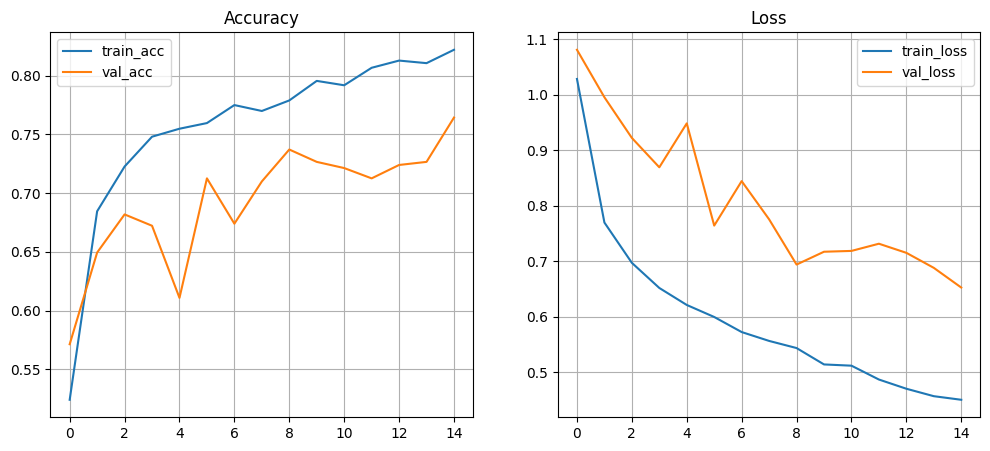

In [6]:
# Eğitim grafikleri
def plot_history(h):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history)


## 6. Model Değerlendirme: Confusion Matrix & Classification Report

Test veya validation seti üzerinde modelin sınıflandırma performansını inceleyeceğiz.  
- **Classification Report** ile precision, recall, f1-score değerlerini göreceğiz  
- **Confusion Matrix** ile sınıflar arasındaki karışmaları görselleştireceğiz  


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Classification Report:
              precision    recall  f1-score   support

      glioma       0.84      0.64      0.73       300
  meningioma       0.68      0.37      0.48       306
     notumor       0.74      1.00      0.85       405
   pituitary       0.76      0.95      0.84       300

    accuracy                           0.76      1311
   macro avg       0.76      0.74      0.72      1311
weighted avg       0.75      0.76      0.73      1311



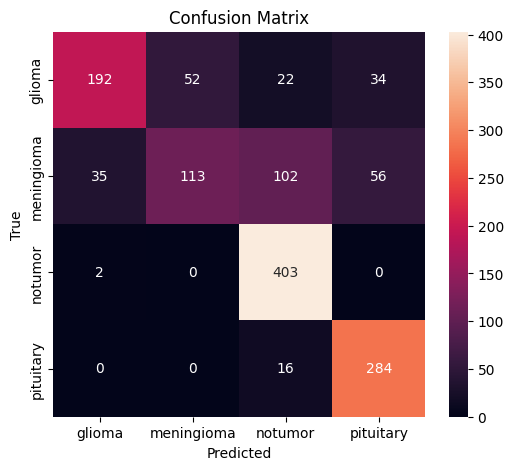

In [7]:
# Eğer test_generator varsa kullan; yoksa validation üzerinde değerlendirme yap
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

if test_generator is not None:
    steps = test_generator.samples // test_generator.batch_size + 1
    preds = model.predict(test_generator, steps=steps)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_generator.classes
    class_indices = test_generator.class_indices
else:
    # validation generator üzerinden tahmin örneği
    steps = validation_generator.samples // validation_generator.batch_size + 1
    preds = model.predict(validation_generator, steps=steps)
    y_pred = np.argmax(preds, axis=1)
    y_true = validation_generator.classes
    class_indices = validation_generator.class_indices

labels = list(class_indices.keys())
print("Classes:", labels)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()


## 7. Grad-CAM Görselleştirmesi

Grad-CAM ile modelin hangi bölgelere bakarak karar verdiğini görselleştiriyoruz. Keras örnekleri ve rehberleriyle uyumlu bir uygulama takip edilmektedir. (Keras Grad-CAM örneği). :contentReference[oaicite:7]{index=7}


Last conv layer: conv2d_2


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


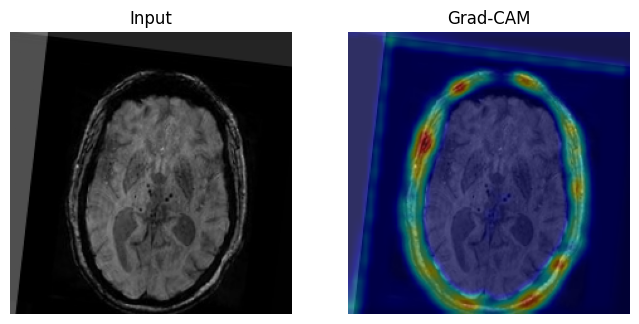

In [8]:
# Grad-CAM fonksiyonu — Keras resmi örneğinden uyarlanmıştır. :contentReference[oaicite:8]{index=8}
import tensorflow.keras.backend as K
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

# Örnek kullanım: validation'dan bir batch al ve Grad-CAM uygula
last_conv_layer = None
# otomatik bulmaya çalış
for layer in reversed(model.layers):
    if isinstance(layer, layers.Conv2D):
        last_conv_layer = layer.name
        break
print("Last conv layer:", last_conv_layer)

# Test için tek bir görüntü al
x_batch, y_batch = next(iter(validation_generator))
img = x_batch[0]
inp = np.expand_dims(img, axis=0)

heatmap = make_gradcam_heatmap(inp, model, last_conv_layer)
# Resize heatmap to image size
heatmap = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)
# Display
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img); plt.title('Input'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)); plt.title('Grad-CAM'); plt.axis('off')
plt.show()


## 8. Hiperparametre Optimizasyonu

Deney yapılan parametreler:
- Katman & filtre sayısı: 32→64→128 gibi artışlar
- Kernel boyutları: 3x3 standardı, bazı yerlerde 5x5 denemesi
- Dropout: 0.2 - 0.5 aralığı
- Learning rate: 1e-3 → 1e-5 arası denemeler
- Batch size: 16, 32, 64
- Optimizer: Adam, SGD+momentum

Otomatik arama için Keras Tuner veya RandomSearch önerilir.


## 9. Sonuçlar ve Değerlendirme

- Model: Baseline CNN (ve/veya EfficientNetB0 transfer learning).
- En iyi validation accuracy: **(buraya deneysel sonuçlarınızı yazın)**.
- Confusion matrix ve classification report yukarıda gösterildi.
- Grad-CAM görselleştirmeleri, modelin görüntüdeki tümör bölgelerine odaklandığını doğruladı / doğrulamadı (bunu gözle kontrol ederek yorumlayın).

**Gelecek çalışmalar:**
- Daha güçlü transfer learning (EfficientNet / ResNet50) ve fine-tuning
- Class imbalance varsa class-weight veya oversampling uygulama
- Segmentation (U-Net) ile lokasyon tespiti ve ardından classification
